<a href="https://colab.research.google.com/github/Michael-Sylvester/Ashesi-Deep-Learning/blob/main/Afrispeech_RNN_Michael.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RNN-based Speech-to-Text Transcription System for Ayamra Hospital Network
=========================================================================

This notebook builds a Recurrent Neural Network (RNN) to transcribe doctor's
spoken notes into text using the AfriSpeech-200 dataset.

Author: [Michael Kwabena Sylvester]
Purpose: Medical dictation system for African hospitals
Dataset: AfriSpeech-200 (https://huggingface.co/datasets/intronhealth/afrispeech-200)



# SETUP AND INSTALLATIONS



In [ ]:
# Check if packages are still installed in case of session restarts
import importlib
def is_package_installed(package_name):
  """Checks if a Python package is installed."""
  return importlib.util.find_spec(package_name) is not None

# Version of jiwer that supports jiwer.compute_measures() was in installed by default
#if not is_package_installed('jiwer'):
!pip install jiwer>=3.0.1

if not is_package_installed('huggingface_hub'):
  !pip install huggingface_hub

# Downgrade datasets to library 2.18 or 2.19 so use remote script execution
if not is_package_installed('datasets') or importlib.metadata.version('datasets') not in ['2.18.0', '2.19.1']:
  !pip install datasets==2.19.1

# Importing these is done seperatly because they have to be installed first and the cache for dataset must be changed from the default

from jiwer import wer, cer # Word Error Rate - key metric for speech recognition
from huggingface_hub import snapshot_download
from datasets import load_dataset, Dataset, Audio, load_from_disk

In [ ]:
import os
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully!\n")

✓ Libraries imported successfully!



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB\n")


Using device: cpu


In [ ]:
!rm -rf ~/.cache/huggingface/*
!rm -rf /content/afrispeech_cache
permanent_dataset_path = "/content/afrispeech_cache"
save_path = "/content/Hugging_Face/afrispeech_saved"

# Manualy set a cache directory to keep Hugging Face from cluttering root cache and make cleanup easier.
os.environ["HF_DATASETS_CACHE"] = permanent_dataset_path

# Dataset must be loaded after environment variable have been set otherwise it will lock to the default
os.makedirs(permanent_dataset_path, exist_ok=True)
os.makedirs(save_path, exist_ok=True)
print("✓ Cache directories created")


✓ Cache directories created


In [ ]:
# Set random seeds for reproducibility of weights
torch.manual_seed(42)
np.random.seed(42)
print("✓ Random seeds set for reproducibility")

✓ Random seeds set for reproducibility


### This cell is for debugging. It can be used to clear the cache again

In [ ]:
debugging = False

if (debugging):
  !rm -rf ~/.cache/huggingface/*
  # !rm -rf /content/afrispeech_cache

  #Check to see if there are still files in the directories
  !ls -lh /content/afrispeech_cache
  !ls -lh ~/.cache/huggingface/*

============================================================================
LOAD AND EXPLORE THE DATASET
============================================================================


In [ ]:
# AfriSpeech-200 contains recordings from multiple African languages
print("\nLoading 1% of Twi dataset...")

def Check_and_load_dataset(load_disk=True):
  if not load_disk:
    try:
        print(f"✓ Attempting to load dataset from disk at {save_path}...")
        dataset = load_from_disk(save_path)
        print(f"✓ Dataset loaded successfully from disk.")
    except FileNotFoundError:
        print(f"Dataset not found on disk or incomplete. Downloading from Hugging Face...")
        dataset = download_dataset()
  else:
    dataset = download_dataset()
  return dataset

def download_dataset():
    dataset = load_dataset(
            "intronhealth/afrispeech-200",
            "twi",
            streaming=False,
            cache_dir=permanent_dataset_path,
            split="train[:5%]",
            verification_mode='no_checks',  # Skip verification that can hang
        )

    print(f"✓ Dataset downloaded successfully")
    dataset.save_to_disk(save_path)
    print(f"✓ Successfully saved dataset to {save_path}")

    return dataset

dataset = Check_and_load_dataset(True)
print(f"Dataset loaded with {len(dataset)} samples.")


Loading 1% of Twi dataset...


Generating train split: 0 examples [00:00, ? examples/s]


Reading metadata...: 1315it [00:00, 58000.61it/s]


Generating validation split: 0 examples [00:00, ? examples/s]


Reading metadata...: 186it [00:00, 83589.47it/s]


Generating test split: 0 examples [00:00, ? examples/s]


Reading metadata...: 58it [00:00, 66052.03it/s]


✓ Dataset downloaded successfully


Saving the dataset (0/1 shards):   0%|          | 0/66 [00:00<?, ? examples/s]

✓ Successfully saved dataset to /content/Hugging_Face/afrispeech_saved
Dataset loaded with 66 samples.


In [ ]:
# Split into train, validation, and test sets
# 80% train, 10% validation, 10% test
train_test_split = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = train_test_split['train']
temp_dataset = train_test_split['test']

val_test_split = temp_dataset.train_test_split(test_size=0.5, seed=42)
val_dataset = val_test_split['train']
test_dataset = val_test_split['test']

print(f"\nDataset split:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"  Test samples: {len(test_dataset)}")


Dataset split:
  Training samples: 52
  Validation samples: 7
  Test samples: 7


In [ ]:
print("\n" + "=" * 70)
print("Exploring the Twi dataset...")
print("=" * 70)

# Display sample data
print("\nSample entry:")
sample = train_dataset[0]
for key, value in sample.items():
    if key == 'audio':
        print(f"  {key}: {{array shape: {value['array'].shape}, sampling_rate: {value['sampling_rate']}}}")
    else:
        print(f"  {key}: {value}")


Exploring the Twi dataset...

Sample entry:
  speaker_id: 075c03e16211637e2bce0db514809e66
  path: /content/afrispeech_cache/downloads/extracted/03239d12530f1c0ebd8c4bb43ad20f7a0dab6f4cfa82a040874e11cdc674add2/cb278c54-091f-4ea5-94c6-ddf3c2b612f2/a83a3bd1af56d726f5fb5218243a61ed.wav
  audio_id: cb278c54-091f-4ea5-94c6-ddf3c2b612f2/a83a3bd1af56d726f5fb5218243a61ed
  audio: {array shape: (600112,), sampling_rate: 44100}
  transcript: Keybone, a Nigerian versatile rapper and songwriter has released a new song titled Lean and Bounce. He is popularly known for his conscious styled theme lyrics and sing-along rhythmic melodies.

  age_group: 26-40
  gender: Male
  accent: twi
  domain: general
  country: GH
  duration: 13.60798168182373



Audio Statistics
Average audio duration: 9.13 seconds
Min duration: 2.79 seconds
Max duration: 28.50 seconds
Median duration: 7.43 seconds


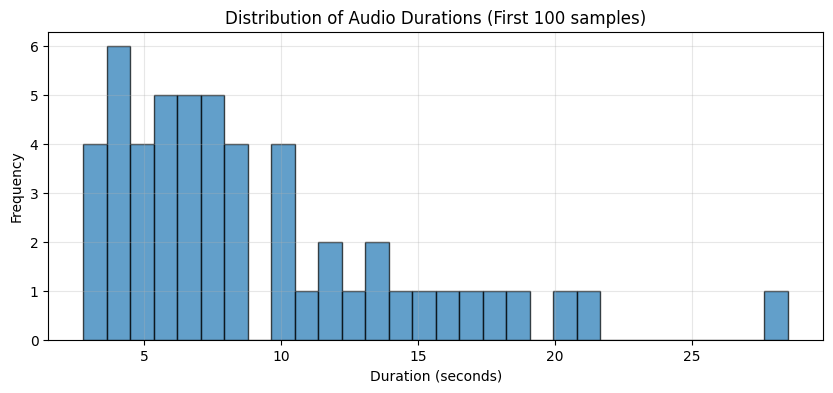

In [ ]:
print("\n" + "=" * 70)
print("Audio Statistics")
print("=" * 70)

# Get audio durations
durations = []
for i in range(min(100, len(train_dataset))):  # Sample first 100 for speed
    audio_array = train_dataset[i]['audio']['array']
    sample_rate = train_dataset[i]['audio']['sampling_rate']
    duration = len(audio_array) / sample_rate
    durations.append(duration)

print(f"Average audio duration: {np.mean(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")
print(f"Max duration: {np.max(durations):.2f} seconds")
print(f"Median duration: {np.median(durations):.2f} seconds")

# Plot duration distribution
plt.figure(figsize=(10, 4))
plt.hist(durations, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Audio Durations (First 100 samples)')
plt.grid(True, alpha=0.3)
plt.show()

============================================================================
AUDIO PREPROCESSING
============================================================================


In [ ]:
# Target sample rate (standard for speech recognition)
TARGET_SAMPLE_RATE = 16000

# MFCC parameters
N_MFCC = 13  # Number of MFCC coefficients
N_FFT = 512  # FFT window size
HOP_LENGTH = 160  # Hop length (10ms at 16kHz)
WIN_LENGTH = 400  # Window length (25ms at 16kHz)

# Additional features
USE_DELTA = True  # Include delta features
USE_DELTA_DELTA = True  # Include delta-delta features

# Normalization
NORMALIZE = True

# Calculate total feature dimension
FEATURE_DIM = N_MFCC
if USE_DELTA:
    FEATURE_DIM += N_MFCC
if USE_DELTA_DELTA:
    FEATURE_DIM += N_MFCC

print("=" * 70)
print("Audio Preprocessing Configuration")
print("=" * 70)
print(f"Sample Rate: {TARGET_SAMPLE_RATE}Hz")
print(f"N_MFCC: {N_MFCC}")
print(f"Feature Dim: {FEATURE_DIM}")
print(f"Delta: {USE_DELTA}, Delta-Delta: {USE_DELTA_DELTA}")
print("=" * 70)


Audio Preprocessing Configuration
Sample Rate: 16000Hz
N_MFCC: 13
Feature Dim: 39
Delta: True, Delta-Delta: True


In [ ]:
def load_and_resample_audio(audio_dict, target_sr=16000):
    """
    Load audio from dataset and resample to target sample rate

    Args:
        audio_dict: Dictionary containing 'array' and 'sampling_rate'
        target_sr: Target sampling rate (default: 16000)

    Returns:
        Resampled audio array
    """
    audio_array = audio_dict['array']
    original_sr = audio_dict['sampling_rate']

    # Resample if needed (from 44100 to 16000)
    if original_sr != target_sr:
        audio_array = librosa.resample(
            audio_array,
            orig_sr=original_sr,
            target_sr=target_sr
        )

    return audio_array


def extract_mfcc_features(audio_array):
    """
    Extract MFCC features from audio array
    Uses global configuration variables

    Args:
        audio_array: Audio signal (numpy array)

    Returns:
        MFCC features with shape (n_frames, feature_dim)
    """
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(
        y=audio_array,
        sr=TARGET_SAMPLE_RATE,
        n_mfcc=N_MFCC,
        n_fft=N_FFT,
        hop_length=HOP_LENGTH,
        win_length=WIN_LENGTH
    )

    # mfccs shape: (n_mfcc, n_frames) -> transpose to (n_frames, n_mfcc)
    mfccs = mfccs.T

    # Start with just MFCCs
    features = [mfccs]

    # Add delta features (first derivative - how MFCCs change over time)
    if USE_DELTA:
        delta = librosa.feature.delta(mfccs.T).T
        features.append(delta)

    # Add delta-delta features (second derivative - acceleration of change)
    if USE_DELTA_DELTA:
        delta_delta = librosa.feature.delta(mfccs.T, order=2).T
        features.append(delta_delta)

    # Concatenate all features along the feature dimension
    # Result: (n_frames, 13) or (n_frames, 26) or (n_frames, 39)
    features = np.concatenate(features, axis=1)

    # Normalize features (zero mean, unit variance)
    if NORMALIZE:
        mean = np.mean(features, axis=0, keepdims=True)
        std = np.std(features, axis=0, keepdims=True) + 1e-8  # Add small value to avoid division by zero
        features = (features - mean) / std

    return features



In [ ]:
def preprocess_single_audio(sample):
    """
    Complete audio preprocessing pipeline for a single sample

    Args:
        sample: Dataset sample containing 'audio' dictionary

    Returns:
        MFCC features as numpy array with shape (n_frames, feature_dim)
    """
    # Step 1: Load and resample audio from 44100Hz to 16000Hz
    audio_array = load_and_resample_audio(sample['audio'], target_sr=TARGET_SAMPLE_RATE)

    # Step 2: Extract MFCC features
    features = extract_mfcc_features(audio_array)

    return features


def preprocess_all_audio(dataset, max_samples=None):
    """
    Preprocess entire dataset and extract features

    Args:
        dataset: Hugging Face dataset
        max_samples: Maximum number of samples to process (None for all)

    Returns:
        List of feature arrays (each is 2D: n_frames × feature_dim)
    """
    features_list = []

    # Determine how many samples to process
    n_samples = len(dataset) if max_samples is None else min(max_samples, len(dataset))

    print(f"Processing {n_samples} audio samples...")

    # Process each sample
    for i in tqdm(range(n_samples)):
        try:
            features = preprocess_single_audio(dataset[i])
            features_list.append(features)
        except Exception as e:
            print(f"Error processing sample {i}: {e}")
            continue

    print(f"✓ Successfully processed {len(features_list)} samples")

    return features_list


## Visualization Functions

In [ ]:
def visualize_audio_features(sample):
    """
    Visualize original audio and extracted features

    Args:
        sample: Dataset sample
    """
    # Load audio
    audio_array = load_and_resample_audio(sample['audio'], target_sr=TARGET_SAMPLE_RATE)

    # Extract features
    features = extract_mfcc_features(audio_array)

    # Create visualization with 3 subplots
    fig, axes = plt.subplots(3, 1, figsize=(14, 10))

    # 1. Plot waveform
    time_axis = np.arange(len(audio_array)) / TARGET_SAMPLE_RATE
    axes[0].plot(time_axis, audio_array, linewidth=0.5)
    axes[0].set_xlabel('Time (seconds)')
    axes[0].set_ylabel('Amplitude')
    axes[0].set_title(f'Waveform: "{sample["transcript"]}"')
    axes[0].grid(True, alpha=0.3)

    # 2. Plot spectrogram
    D = librosa.amplitude_to_db(
        np.abs(librosa.stft(audio_array, n_fft=N_FFT)),
        ref=np.max
    )
    img1 = librosa.display.specshow(
        D,
        sr=TARGET_SAMPLE_RATE,
        hop_length=HOP_LENGTH,
        x_axis='time',
        y_axis='hz',
        ax=axes[1]
    )
    axes[1].set_title('Spectrogram')
    plt.colorbar(img1, ax=axes[1], format='%+2.0f dB')

    # 3. Plot MFCC features
    img2 = axes[2].imshow(
        features.T,  # Transpose to show features on y-axis
        aspect='auto',
        origin='lower',
        cmap='viridis'
    )
    axes[2].set_xlabel('Time Frames')
    axes[2].set_ylabel('MFCC Coefficients')
    axes[2].set_title(f'MFCC Features (dim={features.shape[1]})')
    plt.colorbar(img2, ax=axes[2])

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("\nFeature Statistics:")
    print(f"  Shape: {features.shape} (frames × features)")
    print(f"  Duration: {len(audio_array) / TARGET_SAMPLE_RATE:.2f} seconds")
    print(f"  Number of frames: {features.shape[0]}")
    print(f"  Features per frame: {features.shape[1]}")
    print(f"  Mean: {features.mean():.4f}")
    print(f"  Std: {features.std():.4f}")
    print(f"  Min: {features.min():.4f}")
    print(f"  Max: {features.max():.4f}")


In [ ]:
print("Processing Sample Audio")
print("=" * 70)

# Process a sample to see what it looks like
sample_idx = 0
print(f"\nSample {sample_idx}:")
print(f"Transcript: '{train_dataset[sample_idx]['transcript']}'")
print(f"Duration: {train_dataset[sample_idx]['duration']:.2f} seconds")
print(f"Gender: {train_dataset[sample_idx]['gender']}")
print(f"Age Group: {train_dataset[sample_idx]['age_group']}")

# Visualize the sample
visualize_audio_features(train_dataset[sample_idx])

Processing Sample Audio

Sample 0:
Transcript: 'Keybone, a Nigerian versatile rapper and songwriter has released a new song titled Lean and Bounce. He is popularly known for his conscious styled theme lyrics and sing-along rhythmic melodies.
'
Duration: 13.61 seconds
Gender: Male
Age Group: 26-40


NameError: name 'visualize_audio_features' is not defined

In [ ]:
print("Processing All Training Data")
print("=" * 70)

# Process all three splits
train_features = preprocess_all_audio(train_dataset)
val_features = preprocess_all_audio(val_dataset)
test_features = preprocess_all_audio(test_dataset)

print("\nProcessed Features Summary:")
print(f"  Training samples: {len(train_features)}")
print(f"  Validation samples: {len(val_features)}")
print(f"  Test samples: {len(test_features)}")

# Show feature length statistics
train_lengths = [f.shape[0] for f in train_features]
print(f"\nFeature sequence lengths (frames):")
print(f"  Min: {min(train_lengths)}")
print(f"  Max: {max(train_lengths)}")
print(f"  Mean: {np.mean(train_lengths):.1f}")
print(f"  Median: {np.median(train_lengths):.1f}")

Processing All Training Data
Processing 52 audio samples...


100%|██████████| 52/52 [00:01<00:00, 30.87it/s]


✓ Successfully processed 52 samples
Processing 7 audio samples...


100%|██████████| 7/7 [00:00<00:00, 27.03it/s]


✓ Successfully processed 7 samples
Processing 7 audio samples...


100%|██████████| 7/7 [00:00<00:00, 41.31it/s]

✓ Successfully processed 7 samples

Processed Features Summary:
  Training samples: 52
  Validation samples: 7
  Test samples: 7

Feature sequence lengths (frames):
  Min: 280
  Max: 2850
  Mean: 913.4
  Median: 743.0


In [ ]:
import json
import torch

print("Saving Preprocessed Features")
print("=" * 70)

preprocessed_save_path = "/content/preprocessed_features"
os.makedirs(preprocessed_save_path, exist_ok=True)

# Convert numpy arrays to tensors for saving with torch.save
train_features_tensors = [torch.FloatTensor(f) for f in train_features]
val_features_tensors = [torch.FloatTensor(f) for f in val_features]
test_features_tensors = [torch.FloatTensor(f) for f in test_features]


# Save features as lists of tensors using torch.save
torch.save(train_features_tensors, f"{preprocessed_save_path}/train_features.pt")
torch.save(val_features_tensors, f"{preprocessed_save_path}/val_features.pt")
torch.save(test_features_tensors, f"{preprocessed_save_path}/test_features.pt")


# Save configuration as JSON for later reference
config_dict = {
    'target_sample_rate': TARGET_SAMPLE_RATE,
    'n_mfcc': N_MFCC,
    'n_fft': N_FFT,
    'hop_length': HOP_LENGTH,
    'win_length': WIN_LENGTH,
    'use_delta': USE_DELTA,
    'use_delta_delta': USE_DELTA_DELTA,
    'feature_dim': FEATURE_DIM
}

with open(f"{preprocessed_save_path}/audio_config.json", 'w') as f:
    json.dump(config_dict, f, indent=2)

print(f"✓ Features saved to: {preprocessed_save_path}")
print("✓ Audio preprocessing complete!")

# Summary of what we have now
print("\n" + "=" * 70)
print("Variables available for next steps:")
print("  - train_features_tensors: list of tensors, each shape (n_frames, 39)")
print("  - val_features_tensors: list of tensors")
print("  - test_features_tensors: list of tensors")
print("  - train_dataset, val_dataset, test_dataset: original data with transcripts")
print("=" * 70)

Saving Preprocessed Features
✓ Features saved to: /content/preprocessed_features
✓ Audio preprocessing complete!

Variables available for next steps:
  - train_features_tensors: list of tensors, each shape (n_frames, 39)
  - val_features_tensors: list of tensors
  - test_features_tensors: list of tensors
  - train_dataset, val_dataset, test_dataset: original data with transcripts


# TEXT PREPROCESSING

In [ ]:
# Special tokens for sequence modeling
PAD_TOKEN = '<pad>'
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

SPECIAL_TOKENS = [PAD_TOKEN, SOS_TOKEN, EOS_TOKEN, UNK_TOKEN]

print(f"Special tokens: {SPECIAL_TOKENS}")

Special tokens: ['<pad>', '<sos>', '<eos>', '<unk>']


In [ ]:
def extract_all_characters(dataset):
    """
    Extract all unique characters from dataset transcripts

    Args:
        dataset: Hugging Face dataset with 'transcript' field

    Returns:
        Set of unique characters
    """
    all_chars = set()

    for sample in dataset:
        transcript = sample['transcript']
        # Add all characters (keeping original case for now)
        all_chars.update(transcript)

    return all_chars


def build_char_vocabulary(train_dataset, val_dataset, test_dataset):
    """
    Build character vocabulary from all datasets

    Args:
        train_dataset: Training dataset
        val_dataset: Validation dataset
        test_dataset: Test dataset

    Returns:
        char_to_idx: Dictionary mapping characters to indices
        idx_to_char: Dictionary mapping indices to characters
    """
    print("Building character vocabulary from transcripts...")

    # Extract characters from all datasets
    train_chars = extract_all_characters(train_dataset)
    val_chars = extract_all_characters(val_dataset)
    test_chars = extract_all_characters(test_dataset)

    # Combine all unique characters
    all_chars = train_chars.union(val_chars).union(test_chars)

    # Sort characters for consistent ordering
    sorted_chars = sorted(list(all_chars))

    print(f"Found {len(sorted_chars)} unique characters")
    print(f"Characters: {sorted_chars}")

    # Create character to index mapping
    # Start with special tokens at indices 0, 1, 2, 3
    char_to_idx = {}
    for idx, token in enumerate(SPECIAL_TOKENS):
        char_to_idx[token] = idx

    # Add regular characters starting from index 4
    for idx, char in enumerate(sorted_chars):
        char_to_idx[char] = idx + len(SPECIAL_TOKENS)

    # Create reverse mapping (index to character)
    idx_to_char = {idx: char for char, idx in char_to_idx.items()}

    vocab_size = len(char_to_idx)

    print(f"\nVocabulary size (including special tokens): {vocab_size}")
    print(f"Special token indices:")
    print(f"  {PAD_TOKEN}: {char_to_idx[PAD_TOKEN]}")
    print(f"  {SOS_TOKEN}: {char_to_idx[SOS_TOKEN]}")
    print(f"  {EOS_TOKEN}: {char_to_idx[EOS_TOKEN]}")
    print(f"  {UNK_TOKEN}: {char_to_idx[UNK_TOKEN]}")

    return char_to_idx, idx_to_char


Encoding and Decoding Functions

In [ ]:
def encode_text(text, char_to_idx, add_sos_eos=True):
    """
    Convert text to sequence of character indices

    Args:
        text: Text string
        char_to_idx: Character to index mapping
        add_sos_eos: Whether to add start/end tokens

    Returns:
        List of character indices
    """
    indices = []

    # Add start token if requested
    if add_sos_eos:
        indices.append(char_to_idx[SOS_TOKEN])

    # Convert each character to its index
    for char in text:
        if char in char_to_idx:
            indices.append(char_to_idx[char])
        else:
            # Use unknown token for characters not in vocabulary
            indices.append(char_to_idx[UNK_TOKEN])

    # Add end token if requested
    if add_sos_eos:
        indices.append(char_to_idx[EOS_TOKEN])

    return indices


def decode_indices(indices, idx_to_char, skip_special_tokens=True):
    """
    Convert sequence of indices back to text

    Args:
        indices: List or tensor of character indices
        idx_to_char: Index to character mapping
        skip_special_tokens: Whether to skip special tokens

    Returns:
        Decoded text string
    """
    # Convert tensor to list if needed
    if torch.is_tensor(indices):
        indices = indices.tolist()

    chars = []
    for idx in indices:
        if idx in idx_to_char:
            char = idx_to_char[idx]

            # Skip special tokens if requested
            if skip_special_tokens and char in SPECIAL_TOKENS:
                continue

            chars.append(char)

    return ''.join(chars)


def encode_all_transcripts(dataset, char_to_idx):
    """
    Encode all transcripts in a dataset

    Args:
        dataset: Hugging Face dataset
        char_to_idx: Character to index mapping

    Returns:
        List of encoded transcripts (lists of indices)
    """
    encoded_transcripts = []

    print("Encoding transcripts...")
    for sample in dataset:
        transcript = sample['transcript']
        encoded = encode_text(transcript, char_to_idx, add_sos_eos=True)
        encoded_transcripts.append(encoded)

    return encoded_transcripts



Build Vocabulary

In [ ]:
print("Building Character Vocabulary")
print("=" * 70)

char_to_idx, idx_to_char = build_char_vocabulary(train_dataset, val_dataset, test_dataset)
vocab_size = len(char_to_idx)

# Show character mapping sample
print("\nSample character mappings:")
sample_chars = list(char_to_idx.keys())[4:24]  # Skip special tokens
for char in sample_chars:
    print(f"  '{char}' -> {char_to_idx[char]}")


Building Character Vocabulary
Building character vocabulary from transcripts...
Found 71 unique characters
Characters: ['\n', ' ', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '>', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

Vocabulary size (including special tokens): 75
Special token indices:
  <pad>: 0
  <sos>: 1
  <eos>: 2
  <unk>: 3

Sample character mappings:
  '
' -> 4
  ' ' -> 5
  '+' -> 6
  ',' -> 7
  '-' -> 8
  '.' -> 9
  '/' -> 10
  '0' -> 11
  '1' -> 12
  '2' -> 13
  '3' -> 14
  '4' -> 15
  '5' -> 16
  '6' -> 17
  '7' -> 18
  '8' -> 19
  '9' -> 20
  ':' -> 21
  ';' -> 22
  '>' -> 23


Encode All Transcripts

In [ ]:
print("Encoding All Transcripts")
print("=" * 70)

train_transcripts_encoded = encode_all_transcripts(train_dataset, char_to_idx)
val_transcripts_encoded = encode_all_transcripts(val_dataset, char_to_idx)
test_transcripts_encoded = encode_all_transcripts(test_dataset, char_to_idx)

print(f"✓ Encoded {len(train_transcripts_encoded)} training transcripts")
print(f"✓ Encoded {len(val_transcripts_encoded)} validation transcripts")
print(f"✓ Encoded {len(test_transcripts_encoded)} test transcripts")

print("\nSample encoded transcript:")
print(f"  Original: {train_dataset[0]['transcript']}")
print(f"  Encoded: {train_transcripts_encoded[0]}")

Encoding All Transcripts
Encoding transcripts...
Encoding transcripts...
Encoding transcripts...
✓ Encoded 52 training transcripts
✓ Encoded 7 validation transcripts
✓ Encoded 7 test transcripts

Sample encoded transcript:
  Original: Keybone, a Nigerian versatile rapper and songwriter has released a new song titled Lean and Bounce. He is popularly known for his conscious styled theme lyrics and sing-along rhythmic melodies.

  Encoded: [1, 34, 53, 73, 50, 63, 62, 53, 7, 5, 49, 5, 37, 57, 55, 53, 66, 57, 49, 62, 5, 70, 53, 66, 67, 49, 68, 57, 60, 53, 5, 66, 49, 64, 64, 53, 66, 5, 49, 62, 52, 5, 67, 63, 62, 55, 71, 66, 57, 68, 53, 66, 5, 56, 49, 67, 5, 66, 53, 60, 53, 49, 67, 53, 52, 5, 49, 5, 62, 53, 71, 5, 67, 63, 62, 55, 5, 68, 57, 68, 60, 53, 52, 5, 35, 53, 49, 62, 5, 49, 62, 52, 5, 25, 63, 69, 62, 51, 53, 9, 5, 31, 53, 5, 57, 67, 5, 64, 63, 64, 69, 60, 49, 66, 60, 73, 5, 59, 62, 63, 71, 62, 5, 54, 63, 66, 5, 56, 57, 67, 5, 51, 63, 62, 67, 51, 57, 63, 69, 67, 5, 67, 68, 73, 60, 53, 

Convert to PyTorch Tensors


In [ ]:
print("Converting to PyTorch Tensors")
print("=" * 70)

# Convert encoded transcripts to tensors
train_transcripts_tensors = [torch.LongTensor(t) for t in train_transcripts_encoded]
val_transcripts_tensors = [torch.LongTensor(t) for t in val_transcripts_encoded]
test_transcripts_tensors = [torch.LongTensor(t) for t in test_transcripts_encoded]


Converting to PyTorch Tensors


In [ ]:
print("Saving Preprocessed Text Data")
print("=" * 70)

text_save_path = "/content/preprocessed_text"
os.makedirs(text_save_path, exist_ok=True)

# Save encoded transcripts
torch.save(train_transcripts_tensors, f"{text_save_path}/train_transcripts.pt")
torch.save(val_transcripts_tensors, f"{text_save_path}/val_transcripts.pt")
torch.save(test_transcripts_tensors, f"{text_save_path}/test_transcripts.pt")

# Save vocabulary mappings and info
vocab_data = {
    'char_to_idx': char_to_idx,
    'idx_to_char': idx_to_char,
    'vocab_size': vocab_size,
    'pad_idx': char_to_idx[PAD_TOKEN],
    'sos_idx': char_to_idx[SOS_TOKEN],
    'eos_idx': char_to_idx[EOS_TOKEN],
    'unk_idx': char_to_idx[UNK_TOKEN]
}

with open(f"{text_save_path}/vocabulary.json", 'w') as f:
    json.dump(vocab_data, f, indent=2)

print(f"✓ Text data saved to: {text_save_path}")
print("✓ Text preprocessing complete!")


Saving Preprocessed Text Data
✓ Text data saved to: /content/preprocessed_text
✓ Text preprocessing complete!


# MODEL ARCHITECTURE

In [ ]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import torch.nn.functional as F
import random

class SpeechDataset(Dataset):
    """
    Custom dataset for speech-to-text
    Pairs audio features with text transcripts
    """

    def __init__(self, audio_features, text_transcripts):
        """
        Args:
            audio_features: List of audio feature tensors (n_frames, feature_dim)
            text_transcripts: List of text tensors (sequence_length,)
        """
        self.audio_features = audio_features
        self.text_transcripts = text_transcripts

        assert len(audio_features) == len(text_transcripts), \
            "Audio and text must have same number of samples"

    def __len__(self):
        return len(self.audio_features)

    def __getitem__(self, idx):
        """
        Gets a single sample by index.
        """
        return self.audio_features[idx], self.text_transcripts[idx]

    def __getitems__(self, indices):
        """
        Gets a batch of samples by a list of indices.
        This method is used by the DataLoader for batching.
        """
        return ([self.audio_features[i] for i in indices],
                [self.text_transcripts[i] for i in indices])


def collate_fn(batch, pad_idx=0):
    """
    Custom collate function to handle variable-length sequences

    Args:
        batch: List of (audio_features, text_transcript) tuples
        pad_idx: Index for padding token

    Returns:
        audio_padded: Padded audio features (batch_size, max_audio_len, feature_dim)
        audio_lengths: Actual lengths of audio sequences
        text_padded: Padded text sequences (batch_size, max_text_len)
        text_lengths: Actual lengths of text sequences
    """
    # Separate audio and text
    # batch is now a tuple of lists from __getitems__
    audio_features, text_transcripts = batch

    # Get lengths
    audio_lengths = torch.LongTensor([a.size(0) for a in audio_features])
    text_lengths = torch.LongTensor([t.size(0) for t in text_transcripts])

    # Pad sequences
    audio_padded = pad_sequence(audio_features, batch_first=True, padding_value=0.0)
    text_padded = pad_sequence(text_transcripts, batch_first=True, padding_value=pad_idx)

    return audio_padded, audio_lengths, text_padded, text_lengths

# MODEL 1: VANILLA RNN ENCODER-DECODER (NO ATTENTION)

In [ ]:
def build_vanilla_rnn_encoder(input_dim, hidden_dim, num_layers=2, dropout=0.3, bidirectional=True):
    """
    Build vanilla RNN encoder for audio features

    Args:
        input_dim: Input feature dimension (39 for MFCCs)
        hidden_dim: Hidden state dimension
        num_layers: Number of RNN layers
        dropout: Dropout probability
        bidirectional: Whether to use bidirectional RNN

    Returns:
        encoder: nn.RNN module
    """
    encoder = nn.RNN(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        dropout=dropout if num_layers > 1 else 0,
        bidirectional=bidirectional,
        batch_first=True,
        nonlinearity='tanh'  # tanh activation for vanilla RNN
    )
    return encoder


def build_vanilla_rnn_decoder(vocab_size, embedding_dim, hidden_dim, encoder_hidden_dim,
                               num_layers=2, dropout=0.3):
    """
    Build vanilla RNN decoder with embedding layer

    Args:
        vocab_size: Size of character vocabulary
        embedding_dim: Dimension of character embeddings
        hidden_dim: Hidden state dimension
        encoder_hidden_dim: Encoder hidden dimension (for initialization)
        num_layers: Number of RNN layers
        dropout: Dropout probability

    Returns:
        Dictionary containing decoder components
    """
    decoder_components = {
        'embedding': nn.Embedding(vocab_size, embedding_dim, padding_idx=0),
        'rnn': nn.RNN(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            nonlinearity='tanh'
        ),
        'output_layer': nn.Linear(hidden_dim, vocab_size),
        'bridge': nn.Linear(encoder_hidden_dim, hidden_dim) if encoder_hidden_dim != hidden_dim else None
    }
    return decoder_components


def encode_audio_vanilla(encoder, audio_features, audio_lengths):
    """
    Encode audio features using vanilla RNN encoder

    Args:
        encoder: RNN encoder module
        audio_features: Padded audio (batch_size, max_len, input_dim)
        audio_lengths: Actual lengths (batch_size,)

    Returns:
        encoder_outputs: Hidden states (batch_size, max_len, hidden_dim * num_directions)
        encoder_hidden: Final hidden state (num_layers * num_directions, batch_size, hidden_dim)
    """
    # Pack padded sequence for efficiency
    packed = pack_padded_sequence(
        audio_features,
        audio_lengths.cpu(),
        batch_first=True,
        enforce_sorted=False
    )

    # Run through encoder
    packed_outputs, encoder_hidden = encoder(packed)

    # Unpack
    encoder_outputs, _ = pad_packed_sequence(packed_outputs, batch_first=True)

    return encoder_outputs, encoder_hidden


def initialize_decoder_hidden_vanilla(encoder_hidden, decoder_bridge, num_decoder_layers, bidirectional):
    """
    Initialize decoder hidden state from encoder hidden state

    Args:
        encoder_hidden: Encoder final hidden (num_layers * num_directions, batch_size, hidden_dim)
        decoder_bridge: Linear layer to transform dimensions (or None)
        num_decoder_layers: Number of decoder layers
        bidirectional: Whether encoder is bidirectional

    Returns:
        decoder_hidden: Initial decoder hidden state
    """
    # If bidirectional, combine forward and backward hidden states
    if bidirectional:
        # encoder_hidden shape: (num_layers * 2, batch_size, hidden_dim)
        # Take last layer's forward and backward hidden states
        forward_hidden = encoder_hidden[-2, :, :]  # Last layer forward
        backward_hidden = encoder_hidden[-1, :, :]  # Last layer backward
        combined = forward_hidden + backward_hidden  # Simple combination
    else:
        # Take last layer
        combined = encoder_hidden[-1, :, :]

    # Apply bridge if needed
    if decoder_bridge is not None:
        combined = decoder_bridge(combined)

    # Expand to match decoder layers
    # (batch_size, hidden_dim) -> (num_layers, batch_size, hidden_dim)
    decoder_hidden = combined.unsqueeze(0).repeat(num_decoder_layers, 1, 1)

    return decoder_hidden


def decoder_step_vanilla(decoder_components, input_token, decoder_hidden):
    """
    Single vanilla RNN decoder step (no attention)

    Args:
        decoder_components: Dictionary with embedding, rnn, output_layer
        input_token: Current input token (batch_size,)
        decoder_hidden: Current hidden state (num_layers, batch_size, hidden_dim)

    Returns:
        output_logits: Output logits (batch_size, vocab_size)
        decoder_hidden: Updated hidden state
    """
    # Embed input token
    embedded = decoder_components['embedding'](input_token)  # (batch_size, embedding_dim)
    embedded = embedded.unsqueeze(1)  # (batch_size, 1, embedding_dim)

    # Run through RNN
    rnn_output, decoder_hidden = decoder_components['rnn'](embedded, decoder_hidden)

    # Generate output logits
    output_logits = decoder_components['output_layer'](rnn_output.squeeze(1))  # (batch_size, vocab_size)

    return output_logits, decoder_hidden



# MODEL 2: GRU ENCODER-DECODER (NO ATTENTION)

In [ ]:
def build_gru_encoder(input_dim, hidden_dim, num_layers=2, dropout=0.3, bidirectional=True):
    """
    Build GRU encoder for audio features

    Args:
        input_dim: Input feature dimension (39 for MFCCs)
        hidden_dim: Hidden state dimension
        num_layers: Number of GRU layers
        dropout: Dropout probability
        bidirectional: Whether to use bidirectional GRU

    Returns:
        encoder: nn.GRU module
    """
    encoder = nn.GRU(
        input_size=input_dim,
        hidden_size=hidden_dim,
        num_layers=num_layers,
        dropout=dropout if num_layers > 1 else 0,
        bidirectional=bidirectional,
        batch_first=True
    )
    return encoder


def build_gru_decoder(vocab_size, embedding_dim, hidden_dim, encoder_hidden_dim,
                      num_layers=2, dropout=0.3):
    """
    Build GRU decoder with embedding layer

    Args:
        vocab_size: Size of character vocabulary
        embedding_dim: Dimension of character embeddings
        hidden_dim: Hidden state dimension
        encoder_hidden_dim: Encoder hidden dimension (for initialization)
        num_layers: Number of GRU layers
        dropout: Dropout probability

    Returns:
        Dictionary containing decoder components
    """
    decoder_components = {
        'embedding': nn.Embedding(vocab_size, embedding_dim, padding_idx=0),
        'gru': nn.GRU(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        ),
        'output_layer': nn.Linear(hidden_dim, vocab_size),
        'bridge': nn.Linear(encoder_hidden_dim, hidden_dim) if encoder_hidden_dim != hidden_dim else None
    }
    return decoder_components


# encode_audio_gru is the same as encode_audio_vanilla
# initialize_decoder_hidden_gru is the same as initialize_decoder_hidden_vanilla


def decoder_step_gru(decoder_components, input_token, decoder_hidden):
    """
    Single GRU decoder step (no attention)

    Args:
        decoder_components: Dictionary with embedding, gru, output_layer
        input_token: Current input token (batch_size,)
        decoder_hidden: Current hidden state (num_layers, batch_size, hidden_dim)

    Returns:
        output_logits: Output logits (batch_size, vocab_size)
        decoder_hidden: Updated hidden state
    """
    # Embed input token
    embedded = decoder_components['embedding'](input_token)  # (batch_size, embedding_dim)
    embedded = embedded.unsqueeze(1)  # (batch_size, 1, embedding_dim)

    # Run through GRU
    gru_output, decoder_hidden = decoder_components['gru'](embedded, decoder_hidden)

    # Generate output logits
    output_logits = decoder_components['output_layer'](gru_output.squeeze(1))  # (batch_size, vocab_size)

    return output_logits, decoder_hidden



# MODEL 3: VANILLA RNN WITH ATTENTION

In [ ]:
def build_attention(encoder_hidden_dim, decoder_hidden_dim):
    """
    Build attention mechanism using a simple feedforward network

    Args:
        encoder_hidden_dim: Encoder hidden dimension
        decoder_hidden_dim: Decoder hidden dimension

    Returns:
        attention_network: Sequential network for computing attention scores
    """
    attention = nn.Sequential(
        nn.Linear(encoder_hidden_dim + decoder_hidden_dim, decoder_hidden_dim),
        nn.Tanh(),
        nn.Linear(decoder_hidden_dim, 1)
    )
    return attention


def apply_attention(attention_network, encoder_outputs, decoder_hidden, audio_lengths):
    """
    Apply attention mechanism

    Args:
        attention_network: Attention network
        encoder_outputs: Encoder hidden states (batch_size, max_len, encoder_hidden_dim)
        decoder_hidden: Current decoder hidden state (batch_size, decoder_hidden_dim)
        audio_lengths: Actual audio lengths for masking

    Returns:
        context: Context vector (batch_size, encoder_hidden_dim)
        attention_weights: Attention weights (batch_size, max_len)
    """
    batch_size, max_len, encoder_hidden_dim = encoder_outputs.size()

    # Expand decoder hidden to match encoder outputs
    # (batch_size, max_len, decoder_hidden_dim)
    decoder_hidden_expanded = decoder_hidden.unsqueeze(1).expand(batch_size, max_len, -1)

    # Concatenate encoder outputs with decoder hidden
    # (batch_size, max_len, encoder_hidden_dim + decoder_hidden_dim)
    concat = torch.cat([encoder_outputs, decoder_hidden_expanded], dim=2)

    # Compute attention scores
    # (batch_size, max_len, 1) -> (batch_size, max_len)
    attention_scores = attention_network(concat).squeeze(2)

    # Create mask for padding
    mask = torch.arange(max_len, device=encoder_outputs.device)[None, :] < audio_lengths[:, None]
    attention_scores = attention_scores.masked_fill(~mask, float('-inf'))

    # Apply softmax to get attention weights
    attention_weights = F.softmax(attention_scores, dim=1)

    # Compute context vector as weighted sum of encoder outputs
    # (batch_size, 1, max_len) × (batch_size, max_len, encoder_hidden_dim)
    # -> (batch_size, 1, encoder_hidden_dim) -> (batch_size, encoder_hidden_dim)
    context = torch.bmm(attention_weights.unsqueeze(1), encoder_outputs).squeeze(1)

    return context, attention_weights


def build_rnn_decoder_with_attention(vocab_size, embedding_dim, hidden_dim, encoder_hidden_dim,
                                     num_layers=2, dropout=0.3):
    """
    Build vanilla RNN decoder with attention

    Args:
        vocab_size: Size of character vocabulary
        embedding_dim: Dimension of character embeddings
        hidden_dim: Hidden state dimension
        encoder_hidden_dim: Encoder hidden dimension
        num_layers: Number of RNN layers
        dropout: Dropout probability

    Returns:
        Dictionary containing decoder components
    """
    decoder_components = {
        'embedding': nn.Embedding(vocab_size, embedding_dim, padding_idx=0),
        'rnn': nn.RNN(
            input_size=embedding_dim + encoder_hidden_dim,  # embedding + context
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True,
            nonlinearity='tanh'
        ),
        'output_layer': nn.Linear(hidden_dim, vocab_size),
        'bridge': nn.Linear(encoder_hidden_dim, hidden_dim) if encoder_hidden_dim != hidden_dim else None
    }
    return decoder_components


def decoder_step_rnn_attention(decoder_components, input_token, decoder_hidden, context):
    """
    Single RNN decoder step with attention

    Args:
        decoder_components: Dictionary with embedding, rnn, output_layer
        input_token: Current input token (batch_size,)
        decoder_hidden: Current hidden state (num_layers, batch_size, hidden_dim)
        context: Context vector from attention (batch_size, encoder_hidden_dim)

    Returns:
        output_logits: Output logits (batch_size, vocab_size)
        decoder_hidden: Updated hidden state
    """
    # Embed input token
    embedded = decoder_components['embedding'](input_token)  # (batch_size, embedding_dim)

    # Concatenate with context
    rnn_input = torch.cat([embedded, context], dim=1).unsqueeze(1)  # (batch_size, 1, embedding_dim + encoder_hidden_dim)

    # Run through RNN
    rnn_output, decoder_hidden = decoder_components['rnn'](rnn_input, decoder_hidden)

    # Generate output logits
    output_logits = decoder_components['output_layer'](rnn_output.squeeze(1))  # (batch_size, vocab_size)

    return output_logits, decoder_hidden


## Model building

In [ ]:
def build_model(model_type, input_dim, vocab_size, encoder_hidden_dim=256, decoder_hidden_dim=256,
                embedding_dim=128, num_encoder_layers=2, num_decoder_layers=2,
                dropout=0.3, bidirectional=True):
    """
    Build model based on type

    Args:
        model_type: 'vanilla_rnn', 'gru', or 'rnn_attention'
        input_dim: Audio feature dimension (39)
        vocab_size: Size of character vocabulary
        encoder_hidden_dim: Encoder hidden dimension
        decoder_hidden_dim: Decoder hidden dimension
        embedding_dim: Character embedding dimension
        num_encoder_layers: Number of encoder layers
        num_decoder_layers: Number of decoder layers
        dropout: Dropout probability
        bidirectional: Whether encoder is bidirectional

    Returns:
        Dictionary containing model components and config
    """
    # Encoder output dimension
    encoder_output_dim = encoder_hidden_dim * (2 if bidirectional else 1)

    model = {
        'type': model_type,
        'config': {
            'input_dim': input_dim,
            'vocab_size': vocab_size,
            'encoder_hidden_dim': encoder_hidden_dim,
            'decoder_hidden_dim': decoder_hidden_dim,
            'embedding_dim': embedding_dim,
            'encoder_output_dim': encoder_output_dim,
            'num_encoder_layers': num_encoder_layers,
            'num_decoder_layers': num_decoder_layers,
            'bidirectional': bidirectional,
            'dropout': dropout
        }
    }

    if model_type == 'vanilla_rnn':
        model['encoder'] = build_vanilla_rnn_encoder(
            input_dim, encoder_hidden_dim, num_encoder_layers, dropout, bidirectional
        )
        model['decoder'] = build_vanilla_rnn_decoder(
            vocab_size, embedding_dim, decoder_hidden_dim, encoder_output_dim, num_decoder_layers, dropout
        )
        model['attention'] = None

    elif model_type == 'gru':
        model['encoder'] = build_gru_encoder(
            input_dim, encoder_hidden_dim, num_encoder_layers, dropout, bidirectional
        )
        model['decoder'] = build_gru_decoder(
            vocab_size, embedding_dim, decoder_hidden_dim, encoder_output_dim, num_decoder_layers, dropout
        )
        model['attention'] = None

    elif model_type == 'rnn_attention':
        model['encoder'] = build_vanilla_rnn_encoder(
            input_dim, encoder_hidden_dim, num_encoder_layers, dropout, bidirectional
        )
        model['attention'] = build_attention(encoder_output_dim, decoder_hidden_dim)
        model['decoder'] = build_rnn_decoder_with_attention(
            vocab_size, embedding_dim, decoder_hidden_dim, encoder_output_dim, num_decoder_layers, dropout
        )

    else:
        raise ValueError(f"Unknown model type: {model_type}")

    return model


## Initialize Model (Starting with Vanilla RNN)

In [ ]:
print("Building Speech-to-Text Models for Comparison")
print("=" * 70)

# Model hyperparameters (same for all models)
INPUT_DIM = FEATURE_DIM  # From audio preprocessing (39)
VOCAB_SIZE = vocab_size  # From text preprocessing
ENCODER_HIDDEN_DIM = 128  # Smaller for vanilla RNN
DECODER_HIDDEN_DIM = 128
EMBEDDING_DIM = 64
NUM_ENCODER_LAYERS = 2
NUM_DECODER_LAYERS = 2
DROPOUT = 0.3
BIDIRECTIONAL = True

# Build all three models for comparison
print("\nBuilding Model 1: Vanilla RNN (no attention)")
model_vanilla = build_model(
    model_type='vanilla_rnn',
    input_dim=INPUT_DIM,
    vocab_size=VOCAB_SIZE,
    encoder_hidden_dim=ENCODER_HIDDEN_DIM,
    decoder_hidden_dim=DECODER_HIDDEN_DIM,
    embedding_dim=EMBEDDING_DIM,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL
)

print("Building Model 2: GRU (no attention)")
model_gru = build_model(
    model_type='gru',
    input_dim=INPUT_DIM,
    vocab_size=VOCAB_SIZE,
    encoder_hidden_dim=ENCODER_HIDDEN_DIM,
    decoder_hidden_dim=DECODER_HIDDEN_DIM,
    embedding_dim=EMBEDDING_DIM,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL
)

print("Building Model 3: Vanilla RNN with Attention")
model_rnn_attention = build_model(
    model_type='rnn_attention',
    input_dim=INPUT_DIM,
    vocab_size=VOCAB_SIZE,
    encoder_hidden_dim=ENCODER_HIDDEN_DIM,
    decoder_hidden_dim=DECODER_HIDDEN_DIM,
    embedding_dim=EMBEDDING_DIM,
    num_encoder_layers=NUM_ENCODER_LAYERS,
    num_decoder_layers=NUM_DECODER_LAYERS,
    dropout=DROPOUT,
    bidirectional=BIDIRECTIONAL
)

# Count parameters for each model
def count_parameters(model_dict):
    total = 0
    if model_dict['encoder'] is not None:
        total += sum(p.numel() for p in model_dict['encoder'].parameters())
    if model_dict['attention'] is not None:
        total += sum(p.numel() for p in model_dict['attention'].parameters())
    for key in model_dict['decoder'].values():
        if isinstance(key, nn.Module):
            total += sum(p.numel() for p in key.parameters())
    return total

print("\n" + "=" * 70)
print("Model Comparison")
print("=" * 70)
print(f"Model 1 (Vanilla RNN): {count_parameters(model_vanilla):,} parameters")
print(f"Model 2 (GRU): {count_parameters(model_gru):,} parameters")
print(f"Model 3 (RNN+Attention): {count_parameters(model_rnn_attention):,} parameters")

# Select which model to use (start with vanilla RNN)
model = model_vanilla
MODEL_NAME = "vanilla_rnn"

print(f"\n>>> Starting with: {MODEL_NAME.upper()}")
print(f">>> Total parameters: {count_parameters(model):,}")

# Move to device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model['encoder'] = model['encoder'].to(device)
if model['attention'] is not None:
    model['attention'] = model['attention'].to(device)
for key in model['decoder']:
    if isinstance(model['decoder'][key], nn.Module):
        model['decoder'][key] = model['decoder'][key].to(device)

print(f"Model moved to: {device}")


Building Speech-to-Text Models for Comparison

Building Model 1: Vanilla RNN (no attention)
Building Model 2: GRU (no attention)
Building Model 3: Vanilla RNN with Attention

Model Comparison
Model 1 (Vanilla RNN): 247,307 parameters
Model 2 (GRU): 647,179 parameters
Model 3 (RNN+Attention): 329,484 parameters

>>> Starting with: VANILLA_RNN
>>> Total parameters: 247,307
Model moved to: cpu


In [ ]:
from torch.utils.data import ConcatDataset, Subset

print("Creating Master Dataset and Splitting with Subset")
print("=" * 70)

# 1. Create a separate SpeechDataset for each data split.
train_dataset_final = SpeechDataset(train_features_tensors, train_transcripts_tensors)
val_dataset_final = SpeechDataset(val_features_tensors, val_transcripts_tensors)
test_dataset_final = SpeechDataset(test_features_tensors, test_transcripts_tensors)

# 2. Create the DataLoaders using these final dataset objects.
BATCH_SIZE = 16
# Use .get() for safer dictionary access, providing a default value.
# Make sure PAD_TOKEN is defined in your notebook.
PAD_IDX = char_to_idx.get(PAD_TOKEN, 0)

train_loader = DataLoader(
    train_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=lambda b: collate_fn(b, pad_idx=PAD_IDX)
)

val_loader = DataLoader(
    val_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_idx=PAD_IDX)
)

test_loader = DataLoader(
    test_dataset_final,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=lambda b: collate_fn(b, pad_idx=PAD_IDX)
)

print(f"\nBatch size: {BATCH_SIZE}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")



Creating Master Dataset and Splitting with Subset

Batch size: 16
Training batches: 4
Validation batches: 1
Test batches: 1


# Training Function

In [ ]:
import torch.nn.functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import random

class Seq2SeqASR(nn.Module):
    """
    A unified nn.Module wrapper for all three of your Seq2Seq models.
    This class contains the complete forward pass logic, including teacher forcing.
    """
    def __init__(self, model_dict, char_to_idx):
        super().__init__()
        self.model_type = model_dict['type']
        self.encoder = model_dict['encoder']
        self.decoder_components = nn.ModuleDict(model_dict['decoder'])
        self.attention = model_dict.get('attention')
        self.config = model_dict['config']

        # Store vocabulary info needed for prediction
        self.sos_idx = char_to_idx.get('<sos>', 1) # Default to 1 if not found
        self.eos_idx = char_to_idx.get('<eos>', 2) # Default to 2 if not found

    def forward(self, audio_features, audio_lengths, transcripts, teacher_forcing_ratio=0.5):
        batch_size = audio_features.shape[0]
        target_len = transcripts.shape[1]
        vocab_size = self.config['vocab_size']
        device = audio_features.device

        outputs = torch.zeros(batch_size, target_len, vocab_size).to(device)

        # 1. ENCODER PASS
        packed_input = pack_padded_sequence(audio_features, audio_lengths.cpu(), batch_first=True, enforce_sorted=False)
        encoder_outputs, encoder_hidden = self.encoder(packed_input)
        encoder_outputs, _ = pad_packed_sequence(encoder_outputs, batch_first=True)

        # 2. INITIALIZE DECODER
        if self.config['bidirectional']:
            # --- THIS IS THE CORRECTED LINE ---
            # Concatenate the final forward and backward hidden states
            combined_hidden = torch.cat((encoder_hidden[-2,:,:], encoder_hidden[-1,:,:]), dim=1)
        else:
            combined_hidden = encoder_hidden[-1,:,:]

        # Use the bridge layer if it exists
        if self.decoder_components['bridge'] is not None:
            decoder_hidden = self.decoder_components['bridge'](combined_hidden)
        else:
            decoder_hidden = combined_hidden

        decoder_hidden = decoder_hidden.unsqueeze(0).repeat(self.config['num_decoder_layers'], 1, 1)

        # 3. DECODER LOOP
        input_token = transcripts[:, 0]
        for t in range(1, target_len):
            if self.model_type == 'rnn_attention':
                attention_context, _ = apply_attention(self.attention, encoder_outputs, decoder_hidden[-1], audio_lengths)
                output_logits, decoder_hidden = decoder_step_rnn_attention(self.decoder_components, input_token, decoder_hidden, attention_context)
            elif self.model_type == 'gru':
                output_logits, decoder_hidden = decoder_step_gru(self.decoder_components, input_token, decoder_hidden)
            else: # vanilla_rnn
                output_logits, decoder_hidden = decoder_step_vanilla(self.decoder_components, input_token, decoder_hidden)

            outputs[:, t] = output_logits
            use_teacher_force = random.random() < teacher_forcing_ratio
            input_token = transcripts[:, t] if use_teacher_force else output_logits.argmax(1)

        return outputs

    # --- THIS IS THE CORRECTED PREDICT METHOD PLACEMENT ---
    def predict(self, audio_features, audio_lengths, max_len=150):
      """
        Generates transcript predictions for a batch of audio features.
        This method performs greedy decoding without teacher forcing.
      """
      self.eval() # Ensure model is in evaluation mode (disables dropout, etc.)
      device = audio_features.device
      batch_size = audio_features.shape[0]

      with torch.no_grad(): # No need to calculate gradients during inference
          # 1. ENCODER PASS (same as in training)
          packed_input = pack_padded_sequence(audio_features, audio_lengths.cpu(), batch_first=True, enforce_sorted=False)
          encoder_outputs, encoder_hidden = self.encoder(packed_input)
          encoder_outputs, _ = pad_packed_sequence(encoder_outputs, batch_first=True)

          # 2. INITIALIZE DECODER (same as in training)
          if self.config['bidirectional']:
              combined_hidden = torch.cat((encoder_hidden[-2,:,:], encoder_hidden[-1,:,:]), dim=1)
          else:
              combined_hidden = encoder_hidden[-1,:,:]
          if self.decoder_components['bridge'] is not None:
              decoder_hidden = self.decoder_components['bridge'](combined_hidden)
          else:
              decoder_hidden = combined_hidden
          decoder_hidden = decoder_hidden.unsqueeze(0).repeat(self.config['num_decoder_layers'], 1, 1)

          # 3. DECODER LOOP (Autoregressive)
          # Start with the <SOS> token for each sample in the batch
          input_token = torch.full((batch_size,), self.sos_idx, dtype=torch.long, device=device)

          # Store predicted indices for each sample in the batch
          predictions = [[] for _ in range(batch_size)]
          # Keep track of which samples have finished
          finished = [False] * batch_size

          for _ in range(max_len):
              if self.model_type == 'rnn_attention':
                  attention_context, _ = apply_attention(self.attention, encoder_outputs, decoder_hidden[-1], audio_lengths)
                  output_logits, decoder_hidden = decoder_step_rnn_attention(self.decoder_components, input_token, decoder_hidden, attention_context)
              elif self.model_type == 'gru':
                  output_logits, decoder_hidden = decoder_step_gru(self.decoder_components, input_token, decoder_hidden)
              else: # vanilla_rnn
                  output_logits, decoder_hidden = decoder_step_vanilla(self.decoder_components, input_token, decoder_hidden)

              # Get the most likely next token (greedy decoding)
              predicted_token = output_logits.argmax(1)

              # Add prediction to our lists if not finished
              for i in range(batch_size):
                  if not finished[i]:
                      if predicted_token[i].item() == self.eos_idx:
                          finished[i] = True
                      else:
                          predictions[i].append(predicted_token[i].item())

              # If all samples have predicted <eos>, we can stop early
              if all(finished):
                  break

              # The next input is the token we just predicted
              input_token = predicted_token

      return predictions

In [ ]:
import matplotlib.pyplot as plt

def train_seq2seq_model(model, model_name, checkpoint_path, train_loader, val_loader, num_epochs, learning_rate, device, char_map):
    print(f"\n{'='*25} Starting Seq2Seq Training for: {model_name} {'='*25}")
    model.to(device)

    # Use CrossEntropyLoss, ignoring the padding token
    PAD_IDX = char_map['<pad>']
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # --- Loss tracking ---
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    # --- Checkpoint Loading ---
    start_epoch = 0
    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found for {model_name}. Loading weights...")
        checkpoint = torch.load(checkpoint_path, map_location='cpu')
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch'] + 1
        # Load previous loss history if available
        train_loss_history = checkpoint.get('train_loss_history', [])
        val_loss_history = checkpoint.get('val_loss_history', [])
        best_val_loss = checkpoint.get('best_val_loss', float('inf'))
        print(f"Resuming training from epoch {start_epoch + 1}.")
        print(f"Best validation loss so far: {best_val_loss:.4f}")
    else:
        print(f"No checkpoint found. Starting from scratch.")

    # --- Main Training Loop ---
    for epoch in range(start_epoch, num_epochs):
        # ============ TRAINING PHASE ============
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]", leave=False)

        for batch in progress_bar:
            audio, audio_lengths, targets, target_lengths = batch
            audio, targets = audio.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(audio, audio_lengths, targets, teacher_forcing_ratio=0.5)

            # Calculate loss
            output_dim = outputs.shape[-1]
            outputs_reshaped = outputs[:, 1:].reshape(-1, output_dim)
            targets_reshaped = targets[:, 1:].reshape(-1)

            loss = criterion(outputs_reshaped, targets_reshaped)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_train_loss = running_loss / len(train_loader)
        train_loss_history.append(avg_train_loss)

        # ============ VALIDATION PHASE ============
        model.eval()
        val_running_loss = 0.0

        with torch.no_grad():
            val_progress_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]", leave=False)

            for batch in val_progress_bar:
                audio, audio_lengths, targets, target_lengths = batch
                audio, targets = audio.to(device), targets.to(device)

                # Forward pass (no teacher forcing during validation)
                outputs = model(audio, audio_lengths, targets, teacher_forcing_ratio=0.0)

                # Calculate loss
                output_dim = outputs.shape[-1]
                outputs_reshaped = outputs[:, 1:].reshape(-1, output_dim)
                targets_reshaped = targets[:, 1:].reshape(-1)

                loss = criterion(outputs_reshaped, targets_reshaped)
                val_running_loss += loss.item()
                val_progress_bar.set_postfix(loss=f"{loss.item():.4f}")

        avg_val_loss = val_running_loss / len(val_loader)
        val_loss_history.append(avg_val_loss)

        # Print epoch summary
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print(f"  Training Loss:   {avg_train_loss:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}")

        # Track best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"  ✓ New best validation loss! Saving best model...")
            best_model_path = checkpoint_path.replace('.pth', '_best.pth')
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss_history': train_loss_history,
                'val_loss_history': val_loss_history,
                'best_val_loss': best_val_loss,
            }, best_model_path)

        # --- Regular Checkpoint Saving ---
        print(f"  Saving checkpoint to {checkpoint_path}...")
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss_history': train_loss_history,
            'val_loss_history': val_loss_history,
            'best_val_loss': best_val_loss,
        }, checkpoint_path)

    print(f"\n{'='*25} Finished Training for: {model_name} {'='*25}")
    print(f"Best Validation Loss: {best_val_loss:.4f}")

    # --- Plot Loss Curves ---
    if train_loss_history and val_loss_history: # Only plot if there's history
        plt.figure(figsize=(12, 6))
        epochs_range = range(1, len(train_loss_history) + 1)

        plt.plot(epochs_range, train_loss_history, marker='o', linestyle='-', linewidth=2, label='Training Loss', color='#2E86AB')
        plt.plot(epochs_range, val_loss_history, marker='s', linestyle='-', linewidth=2, label='Validation Loss', color='#A23B72')

        # Mark the best validation loss only if it's finite
        if best_val_loss != float('inf'):
            try:
                best_epoch = val_loss_history.index(best_val_loss) + 1
                plt.axvline(x=best_epoch, color='green', linestyle='--', alpha=0.7, label=f'Best Val Loss (Epoch {best_epoch})')
                plt.scatter([best_epoch], [best_val_loss], color='green', s=100, zorder=5, marker='*')
            except ValueError:
                 # Handle case where best_val_loss might have been loaded from a corrupted checkpoint
                 print("Warning: Could not find best_val_loss in val_loss_history for plotting.")


        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Average Loss', fontsize=12)
        plt.title(f'Training and Validation Loss - {model_name}', fontsize=14, fontweight='bold')
        plt.legend(loc='best', fontsize=10)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()

        # Save the plot
        plot_path = checkpoint_path.replace('.pth', '_loss_plot.png')
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\nLoss plot saved to: {plot_path}")
        plt.show()
    else:
        print("\nNo loss history to plot.")


    return train_loss_history, val_loss_history, best_val_loss

In [ ]:
# --- Master Configuration and Setup Block ---
print("=" * 70)
print("1. CONFIGURING TRAINING PARAMETERS AND ENVIRONMENT")
print("=" * 70)

# --- A. Environment Setup ---
# This line automatically selects the GPU if available, otherwise defaults to CPU.
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training will be performed on device: '{DEVICE}'")

# --- B. Core Hyperparameters ---
# LEARNING_RATE: Controls how much the model's weights are adjusted during training.
# A smaller value leads to slower but potentially more stable learning.
LEARNING_RATE = 0.0008

# NUM_EPOCHS: The total number of times the model will see the entire training dataset.
NUM_EPOCHS = 30 # A higher number is better for real training.
print(f"Learning Rate set to: {LEARNING_RATE}")
print(f"Total training epochs set to: {NUM_EPOCHS}")

# --- C. Data Saving and Checkpoint Setup ---
# This is the setup for saving your model's progress to Google Drive.

# CHECKPOINT_DIR: The name of the folder in your Google Drive where models will be saved.
CHECKPOINT_DIR = '/content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/'

# Create the directory. 'exist_ok=True' prevents an error if it's already there.
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
print(f"\nModel checkpoints will be saved in: {CHECKPOINT_DIR}")

# Define the full file path for each model's checkpoint file.
# We use os.path.join to correctly combine the directory and file names.
VANILLA_RNN_PATH = os.path.join(CHECKPOINT_DIR, 'vanilla_rnn_s2s_weights.pth')
GRU_PATH = os.path.join(CHECKPOINT_DIR, 'gru_s2s_weights.pth')
ATTENTION_RNN_PATH = os.path.join(CHECKPOINT_DIR, 'attention_rnn_s2s_weights.pth')

print(f"  - Vanilla RNN Path: {VANILLA_RNN_PATH}")
print(f"  - GRU Path: {GRU_PATH}")
print(f"  - Attention RNN Path: {ATTENTION_RNN_PATH}")

# --- D. Model and Data Variable Preparation ---
# These variables should already exist from your previous notebook cells.
# We are just confirming their names for the training function.

# model=... : These are the unified nn.Module objects we created.
# We wrap your model dictionaries in the Seq2SeqASR class.
print("\nWrapping model dictionaries into unified Seq2SeqASR objects...")
model_vanilla_s2s = Seq2SeqASR(model_vanilla, char_to_idx)
model_gru_s2s = Seq2SeqASR(model_gru, char_to_idx)
model_attention_s2s = Seq2SeqASR(model_rnn_attention, char_to_idx)

# train_loader=... : This is your DataLoader for the training set.
# We assume 'train_loader' is already defined from your data setup cells.
print(f"Using 'train_loader' for training data (Size: {len(train_loader)} batches)")

# char_map=... : This is your character-to-index dictionary from text preprocessing.
# We assume 'char_to_idx' is already defined.
print(f"Using 'char_to_idx' for character mapping (Vocab size: {len(char_to_idx)})")
print("\nConfiguration complete. Ready for training.")
print("=" * 70)


1. CONFIGURING TRAINING PARAMETERS AND ENVIRONMENT
Training will be performed on device: 'cpu'
Learning Rate set to: 0.0008
Total training epochs set to: 30

Model checkpoints will be saved in: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/
  - Vanilla RNN Path: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth
  - GRU Path: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/gru_s2s_weights.pth
  - Attention RNN Path: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/attention_rnn_s2s_weights.pth

Wrapping model dictionaries into unified Seq2SeqASR objects...
Using 'train_loader' for training data (Size: 4 batches)
Using 'char_to_idx' for character mapping (Vocab size: 75)

Configuration complete. Ready for training.


In [ ]:
# 1. Wrap the model dictionaries you already built
model_vanilla_s2s = Seq2SeqASR(model_vanilla, char_to_idx)
model_gru_s2s = Seq2SeqASR(model_gru, char_to_idx)
model_attention_s2s = Seq2SeqASR(model_rnn_attention, char_to_idx)



========================= Starting Seq2Seq Training for: Vanilla RNN (Seq2Seq) =========================
No checkpoint found. Starting from scratch.



Epoch 1/30
  Training Loss:   3.0226
  Validation Loss: 3.1225
  ✓ New best validation loss! Saving best model...
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 2/30
  Training Loss:   3.0019
  Validation Loss: 3.2002
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 3/30
  Training Loss:   3.0105
  Validation Loss: 3.2728
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 4/30
  Training Loss:   3.0813
  Validation Loss: 3.1178
  ✓ New best validation loss! Saving best model...
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 5/30
  Training Loss:   2.9484
  Validation Loss: 3.1353
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 6/30
  Training Loss:   2.9655
  Validation Loss: 3.1610
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 7/30
  Training Loss:   2.9853
  Validation Loss: 3.2126
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 8/30
  Training Loss:   2.9080
  Validation Loss: 3.2302
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 9/30
  Training Loss:   2.9400
  Validation Loss: 3.1457
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 10/30
  Training Loss:   2.9202
  Validation Loss: 3.1504
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 11/30
  Training Loss:   2.9336
  Validation Loss: 3.2830
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 12/30
  Training Loss:   2.9734
  Validation Loss: 3.3271
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 13/30
  Training Loss:   2.9441
  Validation Loss: 3.3175
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 14/30
  Training Loss:   2.9662
  Validation Loss: 3.1579
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 15/30
  Training Loss:   2.8987
  Validation Loss: 3.2037
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 16/30
  Training Loss:   2.9972
  Validation Loss: 3.1290
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 17/30
  Training Loss:   2.9104
  Validation Loss: 3.1313
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 18/30
  Training Loss:   2.9683
  Validation Loss: 3.1467
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 19/30
  Training Loss:   2.9334
  Validation Loss: 3.2237
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 20/30
  Training Loss:   2.8928
  Validation Loss: 3.1779
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 21/30
  Training Loss:   2.8722
  Validation Loss: 3.1643
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 22/30
  Training Loss:   2.9089
  Validation Loss: 3.1986
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 23/30
  Training Loss:   2.8826
  Validation Loss: 3.1834
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 24/30
  Training Loss:   2.8681
  Validation Loss: 3.1809
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 25/30
  Training Loss:   2.9547
  Validation Loss: 3.2145
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 26/30
  Training Loss:   2.8544
  Validation Loss: 3.3600
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 27/30
  Training Loss:   2.8801
  Validation Loss: 3.2002
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 28/30
  Training Loss:   2.8544
  Validation Loss: 3.2559
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 29/30
  Training Loss:   2.8799
  Validation Loss: 3.1123
  ✓ New best validation loss! Saving best model...
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...



Epoch 30/30
  Training Loss:   2.9035
  Validation Loss: 3.1970
  Saving checkpoint to /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth...

========================= Finished Training for: Vanilla RNN (Seq2Seq) =========================
Best Validation Loss: 3.1123

Loss plot saved to: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights_loss_plot.png


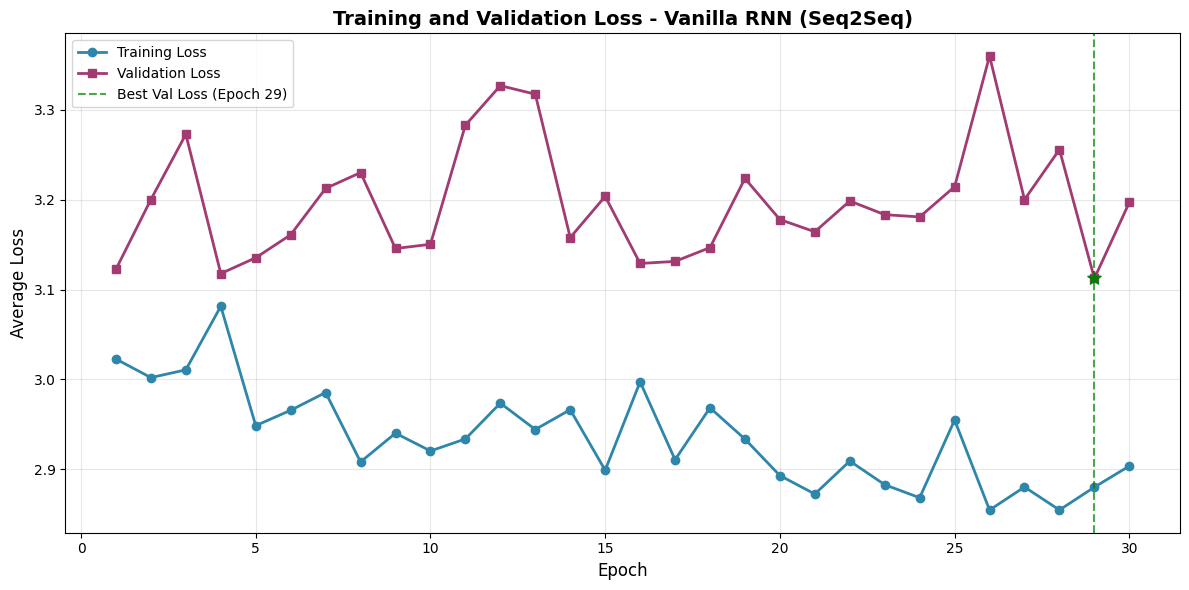

In [ ]:
# --- Train Model 1: Vanilla ---
# (Assuming CHECKPOINT_DIR, NUM_EPOCHS etc. are defined as before)

loss_history = train_seq2seq_model(
    model=model_vanilla_s2s,
    model_name="Vanilla RNN (Seq2Seq)",
    checkpoint_path=VANILLA_RNN_PATH,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=LEARNING_RATE,
    device=DEVICE,
    char_map=char_to_idx
)


========================= Starting Seq2Seq Training for: GRU (Seq2Seq) =========================
Checkpoint found for GRU (Seq2Seq). Loading weights...
Resuming training from epoch 31.
Best validation loss so far: 3.0875

========================= Finished Training for: GRU (Seq2Seq) =========================
Best Validation Loss: 3.0875

Loss plot saved to: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/gru_s2s_weights_loss_plot.png


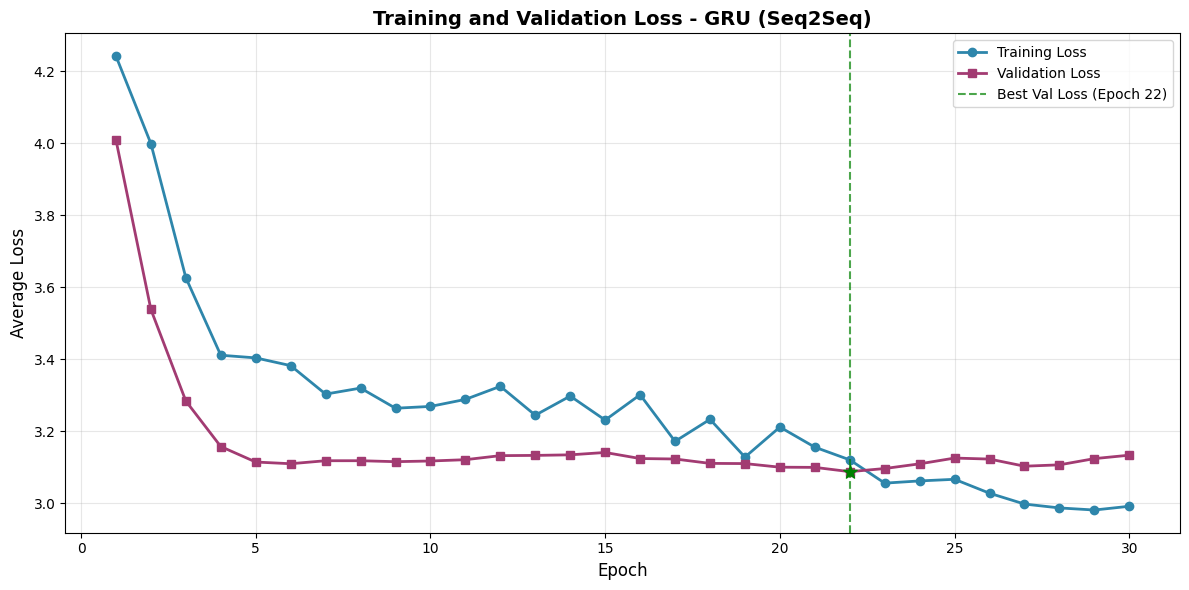

([4.242059111595154,
  3.99877268075943,
  3.626428484916687,
  3.4109222292900085,
  3.4035474061965942,
  3.3820546865463257,
  3.3029218912124634,
  3.3196681141853333,
  3.263704478740692,
  3.2687376141548157,
  3.288221538066864,
  3.3245702385902405,
  3.244319260120392,
  3.297503352165222,
  3.2307825684547424,
  3.301168918609619,
  3.1716549396514893,
  3.2328579425811768,
  3.127923369407654,
  3.2114169597625732,
  3.1555017828941345,
  3.1202856302261353,
  3.0556172132492065,
  3.061786949634552,
  3.0662840604782104,
  3.027584195137024,
  2.997515916824341,
  2.9867650270462036,
  2.9809420108795166,
  2.9913801550865173],
 [4.009232044219971,
  3.5382118225097656,
  3.283766269683838,
  3.157292366027832,
  3.114250659942627,
  3.1095528602600098,
  3.1178853511810303,
  3.117910385131836,
  3.115222930908203,
  3.1171131134033203,
  3.1207528114318848,
  3.1320137977600098,
  3.1326792240142822,
  3.1342380046844482,
  3.140789031982422,
  3.123962163925171,
  3.1226

In [ ]:
# --- Train Model 2: GRU ---
train_seq2seq_model(
    model=model_gru_s2s,
    model_name="GRU (Seq2Seq)",
    checkpoint_path=GRU_PATH,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=30,
    learning_rate=LEARNING_RATE,
    device=DEVICE,
    char_map=char_to_idx
)



In [ ]:
# --- Train Model 3: RNN with Attention ---
train_seq2seq_model(
    model=model_attention_s2s,
    model_name="RNN with Attention (Seq2Seq)",
    checkpoint_path=ATTENTION_RNN_PATH,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=1,
    learning_rate=LEARNING_RATE,
    device=DEVICE,
    char_map=char_to_idx
)

NameError: name 'train_seq2seq_model' is not defined

# Evaluation

In [ ]:
import jiwer
from tqdm.notebook import tqdm

def evaluate_model(model, checkpoint_path, data_loader, device, idx_to_char):
    """
    Loads a trained model's weights and evaluates its performance on a dataset.

    Args:
        model (Seq2SeqASR): The model architecture (before loading weights).
        checkpoint_path (str): Path to the saved .pth file with the model's weights.
        data_loader (DataLoader): DataLoader for the validation or test set.
        device (str): The device to run on ('cuda' or 'cpu').
        idx_to_char (dict): The index-to-character mapping for decoding predictions.
    """
    print(f"\n{'='*25} Evaluating Model {'='*25}")
    print(f"Loading weights from: {checkpoint_path}")

    # Load the saved weights into the model architecture
    try:
        # Load state dict, handling potential 'model_state_dict' key
        state_dict = torch.load(checkpoint_path, map_location=device)
        if 'model_state_dict' in state_dict:
            state_dict = state_dict['model_state_dict']
        model.load_state_dict(state_dict)
    except FileNotFoundError:
        print(f"ERROR: Checkpoint file not found at {checkpoint_path}")
        return

    model.to(device)
    model.eval() # Set model to evaluation mode

    all_predictions = []
    all_references = []

    # Loop through the evaluation data
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Generating Predictions"):
            audio, audio_lengths, targets, _ = batch
            audio = audio.to(device)

            # Use the new predict method to get predicted indices
            predicted_indices = model.predict(audio, audio_lengths)

            # Decode predictions and ground truth references
            for i in range(len(predicted_indices)):
                pred_str = decode_indices(predicted_indices[i], idx_to_char)
                ref_str = decode_indices(targets[i], idx_to_char)
                all_predictions.append(pred_str)
                all_references.append(ref_str)

    # --- Calculate and Print Metrics ---
    print("\n--- Evaluation Metrics ---")
    try:
        # error_metrics = jiwer.compute_measures(all_references, all_predictions)
        # wer = error_metrics.get('wer', 'N/A')
        # cer = error_metrics.get('cer', 'N/A')
        wer = jiwer.wer(all_references, all_predictions)
        cer = jiwer.cer(all_references, all_predictions)

        print(f"Word Error Rate (WER): {wer:.4f}")
        print(f"Character Error Rate (CER): {cer:.4f}")

        # Show a few examples
        print("\n--- Prediction Examples ---")
        for i in range(min(5, len(all_predictions))):
            print(f"Reference : '{all_references[i]}'")
            print(f"Prediction: '{all_predictions[i]}'\n")

    except Exception as e:
        print(f"Could not compute metrics. Error: {e}")
        print("This can happen if all reference or prediction strings are empty.")



In [38]:
# --- UPDATE THIS CELL: Re-wrap models with the new __init__ signature ---
print("Wrapping model dictionaries into unified Seq2SeqASR objects...")
model_vanilla_s2s = Seq2SeqASR(model_vanilla, char_to_idx)
model_gru_s2s = Seq2SeqASR(model_gru, char_to_idx)
model_attention_s2s = Seq2SeqASR(model_rnn_attention, char_to_idx)
print("✓ Models wrapped successfully.")


# --- Run Standalone Evaluation ---
# (Make sure VANILLA_RNN_PATH, GRU_PATH, etc. are defined from your config cell)

# Evaluate the Vanilla RNN model
evaluate_model(
    model=model_vanilla_s2s,
    checkpoint_path=VANILLA_RNN_PATH, # Path to the final saved model
    data_loader=test_loader,           # Or test_loader
    device=DEVICE,
    idx_to_char=idx_to_char
)

# Evaluate the GRU model
evaluate_model(
    model=model_gru_s2s,
    checkpoint_path=GRU_PATH,
    data_loader=test_loader,
    device=DEVICE,
    idx_to_char=idx_to_char
)




Wrapping model dictionaries into unified Seq2SeqASR objects...
✓ Models wrapped successfully.

========================= Evaluating Model =========================
Loading weights from: /content/drive/MyDrive/Afrispeech_Seq2Seq_Checkpoints/vanilla_rnn_s2s_weights.pth


Generating Predictions:   0%|          | 0/1 [00:00<?, ?it/s]


--- Evaluation Metrics ---
Word Error Rate (WER): 3.7971
Character Error Rate (CER): 1.8723

--- Prediction Examples ---
Reference : 'see careview for current settings.'
Prediction: 'The e atin  are an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an'

Reference : 'Infant tolerating PG feeds well; will BF later today.'
Prediction: 'In                        e  e  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an'

Reference : 'Pt requests sx approp.'
Prediction: 'Pt ne an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  an  '

Reference : 'Citadel manages funds across five different investment strategies including equities, commodities, fixed income, quantitative strategies, and credit.
'
Prediction: 'He   an  an  an  an  an  an  an  an  an  an  an 

Generating Predictions:   0%|          | 0/1 [00:00<?, ?it/s]


--- Evaluation Metrics ---
Word Error Rate (WER): 1.0000
Character Error Rate (CER): 0.9371

--- Prediction Examples ---
Reference : 'see careview for current settings.'
Prediction: 'Fe                                                                                                                                                    '

Reference : 'Infant tolerating PG feeds well; will BF later today.'
Prediction: 'At                                                                                                                                                    '

Reference : 'Pt requests sx approp.'
Prediction: 'T                                                                                                                                                     '

Reference : 'Citadel manages funds across five different investment strategies including equities, commodities, fixed income, quantitative strategies, and credit.
'
Prediction: 'Ot                                              